In [1]:
# Author: Chase J. Shyu
# Email: iamhemry@gmail.com
# Created date: June 3rd, 2021
# Updated date: June 7th, 2021
import datetime, math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 2021/04台灣人口 23,514,196
# Wikipedia: https://zh.wikipedia.org/zh-tw/臺灣人口
population_202104 = 23514196
vaccine_prec = 0.65
vacNumber = population_202104*vaccine_prec*2
first_date = datetime.datetime.fromisoformat('2021-03-01')
last_date = datetime.datetime.today() #+ datetime.timedelta(days=-1)

# for read data
csv_filename = 'VaccineCOVID19Taiwan - public.csv'
Date = '公布日期'
StatisticDate = '統計日期'
Event = '事件'
ReleasedVaccine = '累計疫苗釋出'
VaccineCheck = '疫苗檢查'
InjectedAmount = '累計施打'
InjectedAmountCorrect = '校正累計施打'
ConfirmedLocalAmount = '累計本土確診'
ConfirmedLocalDaily = '單日本土確診'
ConfirmedLocalCorrectDaily = '單日本土增補'
DeathAmount = '累計死亡'
DeathDaily = '單日死亡'
ArrivedAmount = '累計疫苗抵臺'
FinalCorrectAmount = '完成本土增補'

# read data
df = pd.read_csv(csv_filename)
df = df[~df[Date].isnull()]
df.loc[:,Date] = df[Date].astype('datetime64[ns]')
df.loc[:,StatisticDate] = df[StatisticDate].astype('datetime64[ns]')
df.set_index(StatisticDate,inplace=True)
ind = (df.index >= first_date + datetime.timedelta(days=-1)) * (df.index < last_date)
df = df[ind]
df.loc[(last_date+datetime.timedelta(days=-1)).strftime('%Y-%m-%d'),InjectedAmountCorrect] = \
    df.loc[(last_date+datetime.timedelta(days=-1)).strftime('%Y-%m-%d'),InjectedAmount]
df['mavg'] = df[InjectedAmountCorrect].interpolate()

#
covid_ylim_max = 800
vac_ylim_times = 1.5
prog_ylim_max = 10
prog_y_interval = 2
figsize = (18, 12)

# for plot
title = '臺灣COVID-19疫苗接種統計報表'
title_prog = '臺灣COVID-19疫苗取得/使用進度'
label_right = '單日本土確診/死亡(人)'
label_left = '累計疫苗接種(%)'
label_bottom = '事件/統計日期(西元)'
label_confirmed = '單日本土確診(人)'
label_correction = '累計校正回歸(人)'
label_death = '單日死亡(人)'
text_population = '臺灣人口基數(2021-04)：'+ f'{population_202104:,}' +'人'
text_last_updated = '最後更新日期：%s'%df.index[-1].strftime('%Y-%m-%d')
confirmedAmount = int(df[ConfirmedLocalAmount].max())
deathDeath = int(df[DeathAmount].max())
text_confirmed_amount = '累計本土確診/死亡：' + f'{confirmedAmount:,}/' + f'{deathDeath:,}' +'人'
text_vaccine_estimation = '假設' + f'{vacNumber:,}' + '劑(總人口x2x%d'%(vaccine_prec*100) + '%)'
text_sign = '資料整理：Chase J. Shyu'

label_sub_bottom = '事件日期(西元)'
label_dose_number = '數量(千劑)'
label_progress = '疫苗取得(%)'
label_wait = '待檢驗(劑)'
label_available = '可施打(劑)'

vaccine_color = 'blue'
death_color = 'red'
confirmd_color = 'pink'
correction_color = 'gold'
#progress_axis_color = 'black'
progress_text_color = 'black'
number_color = 'darkviolet'
availble_color = 'blue'
await_color = 'red'
title_size = 36
label_size = 20
tick_size = 16
legend_title_size = 12
subplot_label_size = 12
event_size = 10
main_alpha = 1
vaccine_lw = 2
sub_lw = 1.5

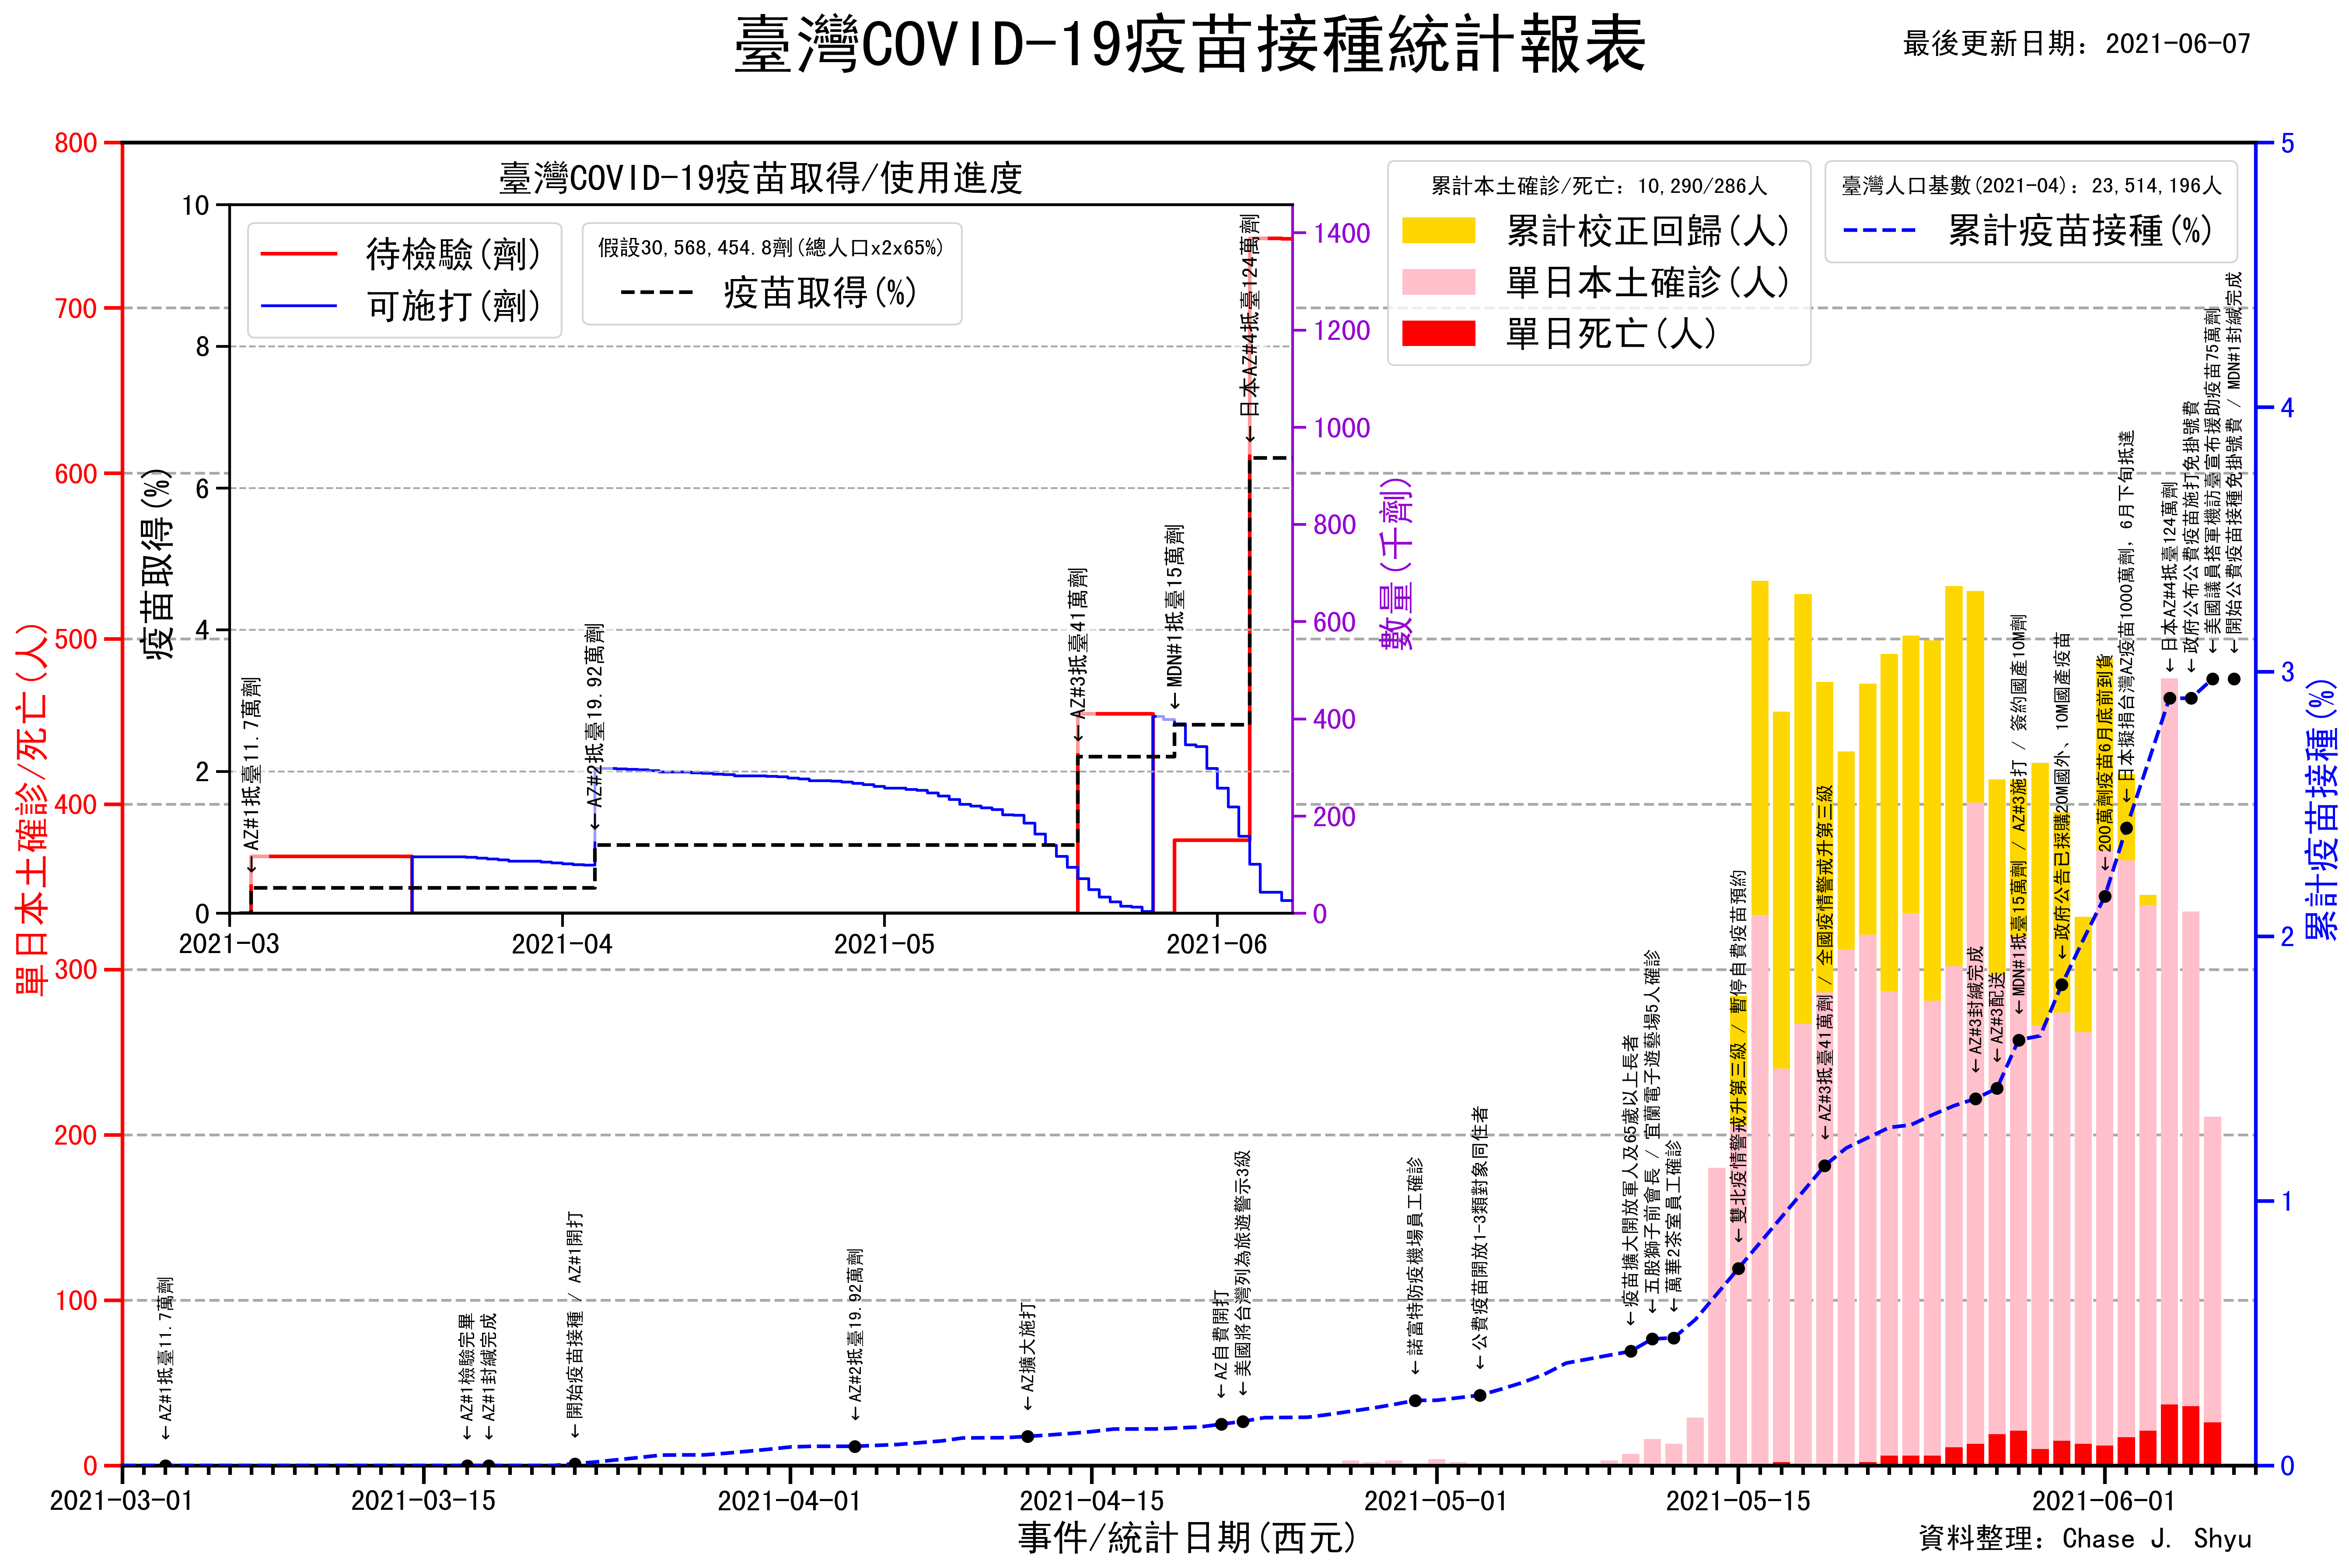

In [3]:
# plot
# https://medium.com/@jackielo_69076/mac-matplotlib-顯示中文-e10c8394300c
#from matplotlib.font_manager import _rebuild
#_rebuild()
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

mpl.rcParams['xtick.labelsize'] = tick_size
mpl.rcParams['ytick.labelsize'] = tick_size
mpl.rcParams['legend.title_fontsize'] = legend_title_size

fig, ax_covid = plt.subplots(1,1,figsize=figsize,dpi=300)
ax_vaccine = ax_covid.twinx()

# plot confirmed case and death
yvalue = df[ConfirmedLocalDaily] + df[FinalCorrectAmount].fillna(0)
ax_covid.bar(df.index, yvalue, color=correction_color,label=label_correction,zorder=10)
ax_covid.bar(df.index, df[ConfirmedLocalDaily], color=confirmd_color,label=label_confirmed,zorder=10)
ax_covid.bar(df.index, df[DeathDaily],color=death_color,label=label_death,zorder=10)

ax_covid.set_ylim(0,covid_ylim_max)
ax_covid.set_ylabel(label_right, fontsize=label_size)
ax_covid.set_xlabel(label_bottom, fontsize=label_size)
ax_covid.spines['left'].set_color(death_color)
ax_covid.spines['right'].set_visible(False)
ax_covid.yaxis.label.set_color(death_color)
ax_covid.tick_params(axis='y',colors=death_color)
for axis in ['top','bottom','left','right']:
    ax_covid.spines[axis].set_linewidth(2)
ax_covid.tick_params(which='major', length=10, width=2)
ax_covid.tick_params(which='minor', length=5, width=2)
ax_covid.patch.set_alpha(main_alpha)
ax_covid.grid(axis='y',linestyle = '--', linewidth = 1.5,zorder=0,color='darkgray')

# plot vaccine injected amount
ind = (~df[InjectedAmountCorrect].isnull()) & (df.index < (last_date + datetime.timedelta(days=-1)))
ax_vaccine.plot(df.index[ind], df[InjectedAmountCorrect][ind]/population_202104*100,
                '--',color=vaccine_color, linewidth = 2,label=label_left,zorder=10)

# text event information
y_shift = ax_vaccine.get_ylim()[1]*0.03
ind = ~df[Event].isnull() & (df[Date] < last_date)
date = df.loc[ind,Date]
for i in df[ind].index:
    ycoord = df.loc[date[i],'mavg'] / population_202104*100 + y_shift
    t = ax_vaccine.text(df.loc[i,Date],ycoord,'$\leftarrow$'+ df.loc[i,Event],
                    rotation=90,fontsize=event_size,horizontalalignment='center',zorder=10)
ax_vaccine.plot(df.loc[ind,Date], df["mavg"][date]/population_202104*100 ,'o',color='black',zorder=10,lw=vaccine_lw)

ax_vaccine.set_zorder(0)
ax_vaccine.set_ylim(0,math.ceil(ax_vaccine.get_ylim()[1] * vac_ylim_times))
ax_vaccine.set_xlim(first_date,df.index[-1]+datetime.timedelta(days=1))
ax_vaccine.set_ylabel(label_left, fontsize=label_size)
ax_vaccine.set_title(title,fontsize=title_size,y=1.05)
ax_vaccine.text(last_date,ax_vaccine.get_ylim()[1]*1.065,
                text_last_updated,
               fontsize=tick_size,ha='right',va='bottom')
ax_vaccine.text(last_date,-ax_vaccine.get_ylim()[1]*0.065,text_sign,fontsize=tick_size,ha='right',va='bottom')
#ax_vaccine.spines['top'].set_visible(False)
ax_vaccine.spines['left'].set_visible(False)
ax_vaccine.spines['right'].set_color(vaccine_color)
for axis in ['top','bottom','left','right']:
    ax_vaccine.spines[axis].set_linewidth(2)
ax_vaccine.yaxis.label.set_color(vaccine_color)
ax_vaccine.tick_params(axis='y',colors=vaccine_color)
ax_vaccine.xaxis.set_minor_locator(mdates.DayLocator())
ax_vaccine.tick_params(which='major', length=10, width=2)
ax_vaccine.patch.set_alpha(main_alpha)

# plot vaccine progress
ax_vac_num = fig.add_axes([0.1, 0.42, .45, 0.45])
ax_progress = ax_vac_num.twinx()

#await vaccion
dd = np.vstack((df[Date][:-1],df[Date][1:])).T.reshape((1,-1),)[0]
yvalue = (df[ArrivedAmount]-df[VaccineCheck].fillna(0).cumsum()-df[ReleasedVaccine])*1e-3
aa = np.vstack((yvalue[:-1],yvalue[:-1])).T.reshape((1,-1),)[0]
ax_vac_num.plot(dd,aa,'-',color=await_color,label=label_wait,lw=2,zorder=5)

# available vaccine
dd = np.vstack((df[Date][:-1],df[Date][1:])).T.reshape((1,-1),)[0]
yvalue = (df[ReleasedVaccine]-df['mavg'].fillna(0))*1e-3
aa = np.vstack((yvalue[:-1],yvalue[:-1])).T.reshape((1,-1),)[0]
ax_vac_num.plot(dd,aa,'-',color=availble_color,label=label_available,lw=sub_lw,zorder=5)

ax_vac_num.set_ylabel(label_dose_number,fontsize=label_size)
ax_vac_num.set_ylim(0,)
ax_vac_num.tick_params(which='major', length=7.5, width=1.5)

for axis in ['top','bottom','right']:
    ax_vac_num.spines[axis].set_linewidth(1.5)
ax_vac_num.spines['right'].set_color(number_color)
ax_vac_num.yaxis.label.set_color(number_color)
ax_vac_num.tick_params(axis='y',colors=number_color)
ax_vac_num.spines['left'].set_visible(False)
ax_vac_num.yaxis.tick_right()
ax_vac_num.yaxis.set_label_position("right")

ax_progress.set_xlim(first_date,df.index[-1]+datetime.timedelta(days=1))
ax_progress.set_ylim(0,prog_ylim_max)

# obtainment
dd = np.vstack((df[Date][:-1],df[Date][1:])).T.reshape((1,-1),)[0]
aa = np.vstack((df[ArrivedAmount][:-1],df[ArrivedAmount][:-1])).T.reshape((1,-1),)[0]
ax_progress.plot(dd,aa / (population_202104*0.7*2) * 100,'--',
                 color=progress_text_color,label=label_progress,lw=2,zorder=5)

y_shift = ax_progress.get_ylim()[1]*0.02
ind = ~df[Event].isnull()
date = df.loc[ind,Date]
for i in df[ind].index:
    if '抵臺' in df.loc[i,Event]:
        ycoord = df.loc[date[i],ArrivedAmount] / (population_202104*0.7*2) * 100 + y_shift
        t = ax_progress.text(df.loc[i,Date],ycoord,'$\leftarrow$'+ df.loc[i,Event].split('/')[0],zorder=6,
                        rotation=90,fontsize=event_size+2,horizontalalignment='center',color=progress_text_color)
        t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none'))

ax_progress.set_title(title_prog,fontsize=label_size,y=1.005)
ax_progress.yaxis.tick_left()
ax_progress.yaxis.set_label_position("left")
ax_progress.set_xlabel(label_sub_bottom,fontsize=label_size)
ax_progress.set_ylabel(label_progress,fontsize=label_size)
ax_progress.set_yticks(np.arange(0, prog_ylim_max+.1, prog_y_interval))
ax_progress.tick_params(axis='y',labelsize=tick_size)
ax_progress.spines['right'].set_visible(False)

#ax_progress.patch.set_alpha(1)
#ax_progress.set_zorder(1)

for axis in ['top','bottom','left']:
    ax_progress.spines[axis].set_linewidth(1.5)
ax_progress.spines['left'].set_color(progress_text_color)
ax_progress.tick_params(which='major', length=7.5, width=1.5)
ax_progress.xaxis.set_major_locator(mdates.MonthLocator())
ax_progress.yaxis.label.set_color(progress_text_color)
ax_progress.tick_params(axis='y',colors=progress_text_color)
ax_progress.grid(axis='y',linestyle = '--', linewidth = 1,color='darkgray')

ax_covid.legend(loc=1,bbox_to_anchor=(0.8, 1),fontsize=label_size,title=text_confirmed_amount)
ax_vaccine.legend(loc=1,bbox_to_anchor=(1, 1),fontsize=label_size,title=text_population)
ax_progress.legend(loc=2,bbox_to_anchor=(0.315, 1),fontsize=label_size,title=text_vaccine_estimation)
ax_vac_num.legend(loc=2,bbox_to_anchor=(0, 1),fontsize=label_size)

# save figure
plt.tight_layout()
plt.savefig('VaccineCOVID19Taiwan-%s.jpg'%df.index[-1].strftime('%Y-%m-%d'),dpi=300)
plt.show()
plt.close()